**BigQuery** adalah gudang data analitik skala petabyte yang dapat Anda gunakan untuk menjalankan kueri SQL atas sejumlah besar data dalam waktu realtime.

Tools visualisasi data dapat membantu memahami data BigQuery Anda dan membantu Anda menganalisis data secara interaktif. Anda dapat menggunakan tools visualisasi untuk membantu Anda mengidentifikasi tren, meresponsnya, dan membuat prediksi menggunakan data Anda. Dalam tutorial ini, Anda menggunakan pustaka klien BigQuery Python dan Pandas di notebook Jupyter untuk memvisualisasikan sampel data [natality](https://console.cloud.google.com/bigquery?p=bigquery-public-data&d=samples&t=natality&page=table&_ga=2.93226717.-1300063973.1540061296&_gac=1.187528794.1551636562.Cj0KCQiAk-7jBRD9ARIsAEy8mh4HRP9IQ3F88GkSuo1UfR2dpY9ZK0cbRSTWi-Tol7uombliusOpxqkaAj5FEALw_wcB) BigQuery.

1. Install library bigquery pandas menggunakan pip
```bash
!pip install --upgrade google-cloud-bigquery[pandas]
```

2. Setting otentikasi menggunakan **Service Account** melalui link berikut ini
   * https://console.cloud.google.com/apis/credentials/serviceaccountkey


In [2]:
from google.cloud.bigquery import magics
from google.oauth2 import service_account

# Atur kredensial menggunakan key.json dari Service Account
credentials = (service_account.Credentials.from_service_account_file('key.json'))
magics.context.credentials = credentials
# Atur project id secara permanen
magics.context.project = 'default-demo-app-d177'

In [1]:
%load_ext google.cloud.bigquery

In [4]:
%%bigquery
SELECT
    source_year AS year,
    COUNT(is_male) AS birth_count
FROM `bigquery-public-data.samples.natality`
GROUP BY year
ORDER BY year DESC
LIMIT 15

,year,birth_count
0,2008,4255156
1,2007,4324008
2,2006,4273225
3,2005,4145619
4,2004,4118907
5,2003,4096092
6,2002,4027376
7,2001,4031531
8,2000,4063823
9,1999,3963465


In [5]:
# Kueri tabel dan menyimpan ke dalam variabel total_births
%%bigquery total_births
SELECT
    source_year AS year,
    COUNT(is_male) AS birth_count
FROM `bigquery-public-data.samples.natality`
GROUP BY year
ORDER BY year DESC
LIMIT 15

In [6]:
%matplotlib inline

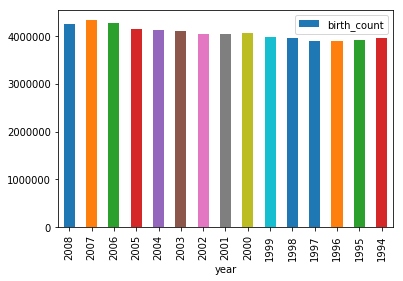

In [7]:
total_births.plot(kind='bar', x='year', y='birth_count');

In [8]:
%%bigquery births_by_weekday
SELECT
    wday,
    SUM(CASE WHEN is_male THEN 1 ELSE 0 END) AS male_births,
    SUM(CASE WHEN is_male THEN 0 ELSE 1 END) AS female_births
FROM `bigquery-public-data.samples.natality`
WHERE wday IS NOT NULL
GROUP BY wday
ORDER BY wday ASC

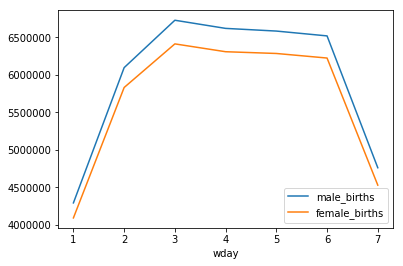

In [9]:
births_by_weekday.plot(x='wday');

## Pandas DataFrames

Magic commands memungkinkan Anda menggunakan sintaks minimal untuk berinteraksi dengan BigQuery. Di belakang layar, `` %%bigquery `` menggunakan pustaka klien BigQuery Python untuk menjalankan kueri yang diberikan, mengkonversi hasilnya menjadi Pandas Dataframe, secara opsional menyimpan hasilnya ke variabel, dan akhirnya menampilkan hasilnya. Menggunakan pustaka klien BigQuery Python secara langsung alih-alih melalui magic commands memberi Anda lebih banyak kontrol atas kueri Anda dan memungkinkan untuk konfigurasi yang lebih kompleks. Integrasi perpustakaan dengan Pandas memungkinkan Anda untuk menggabungkan kekuatan SQL deklaratif dengan kode imperatif (Python) untuk melakukan analisis data yang menarik, visualisasi, dan tugas transformasi.

In [3]:
from google.cloud import bigquery

# Jika kita tidak menfinisikan kredensial ke dalam variabel client
# maka library client akan mencari kredensial dari project yang terhubung sekarang
## client = bigquery.Client()

client = bigquery.Client.from_service_account_json('key.json')

In [4]:
sql = """
SELECT
    plurality,
    COUNT(1) AS count,
    year
FROM
    `bigquery-public-data.samples.natality`
WHERE
    NOT IS_NAN(plurality) AND plurality > 1
GROUP BY
    plurality, year
ORDER BY
    count DESC
"""
df = client.query(sql).to_dataframe()
df.head()

,plurality,count,year
0,2,139209,2007
1,2,138866,2008
2,2,137239,2006
3,2,133285,2005
4,2,132344,2004


In [5]:
pivot_table = df.pivot(index='year', columns='plurality', values='count')
pivot_table.plot(kind='bar', stacked=True, figsize=(15, 7));

In [6]:
sql = """
SELECT
    gestation_weeks,
    COUNT(1) AS count
FROM
    `bigquery-public-data.samples.natality`
WHERE
    NOT IS_NAN(gestation_weeks) AND gestation_weeks <> 99
GROUP BY
    gestation_weeks
ORDER BY
    gestation_weeks
"""
df = client.query(sql).to_dataframe()

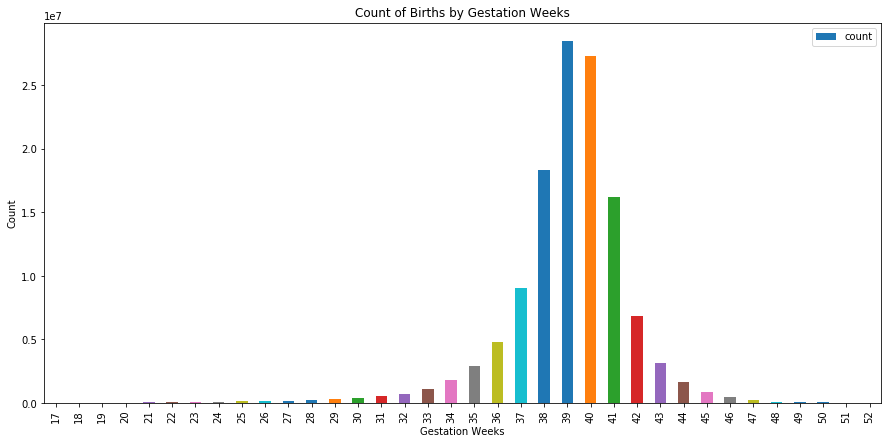

In [7]:
ax = df.plot(kind='bar', x='gestation_weeks', y='count', figsize=(15,7))
ax.set_title('Count of Births by Gestation Weeks')
ax.set_xlabel('Gestation Weeks')
ax.set_ylabel('Count');

**Source** :
* https://cloud.google.com/bigquery/docs/visualize-jupyter
* https://googleapis.github.io/google-cloud-python/latest/bigquery/generated/google.cloud.bigquery.magics.html
* https://cloud.google.com/bigquery/docs/authentication/service-account-file